### Prisoner's dilemma from scratch

In [41]:
import random
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scratch_utils.strategies import (
    Strategy,
    AlwaysCooperate,
    AlwaysDefect,
    TitForTat,
    GrimTrigger,
    Random
)

In [42]:
# Defining the payoff matrix as mentioned in write-up

payoff_matrix = {
    ('C', 'C'): (6, 6),
    ('C', 'D'): (0, 8),
    ('D', 'C'): (8, 0),
    ('D', 'D'): (4, 4)
}

# Defining the paramters of our simulation
rounds = 200 # How many times both players play against each other in each individual game
repetitions = 50 # How many individual games are played between each pair of strategies

In [66]:
# Playing an iterated game between two strategies

def play_game(strategy1, strategy2, rounds):
    # Resetting first
    strategy1.reset()
    strategy2.reset()
    
    score1, score2 = 0, 0
    
    for _ in range(rounds):
        # Moves from the defined strategies
        move1 = strategy1.make_move()
        move2 = strategy2.make_move()
        
        # Traking scores based on the payoff matrix
        payoff1, payoff2 = payoff_matrix[(move1, move2)]
        score1 += payoff1
        score2 += payoff2
        
        # Updating histories
        strategy1.update_history(move1, move2)
        strategy2.update_history(move2, move1)
    
    return score1, score2



# Running a round-robin tournament (each strategy plays against all others)

def run_tournament(strategies, rounds, repetitions):
    # Initializing results
    results = {s.name: 0 for s in strategies}
    matchups = []

    # Round-robin matches
    for i, s1 in enumerate(strategies):
        for s2 in strategies[i:]:
            total_score1, total_score2 = 0, 0
            total_cooperation = 0  # Track cooperation frequency

            for _ in range(repetitions):
                score1, score2 = play_game(s1, s2, rounds)
                total_score1 += score1
                total_score2 += score2

                # Count cooperation moves
                total_cooperation += sum(
                    1 for move1, move2 in zip(s1.history, s2.history) if move1 == "C" and move2 == "C"
                )

            # Update overall results
            results[s1.name] += total_score1
            results[s2.name] += total_score2

            # Store matchup details for visualisation
            matchups.append({
                's1': s1.name,
                's2': s2.name,
                'score1': total_score1,
                'score2': total_score2,
                'cooperation': total_cooperation / (rounds * repetitions)  # Cooperation rate
            })

    return results, matchups


# Main simulation function

""" def run_tournament(strategies, rounds, repetitions):
    # Initializing results
    results = {s.name: 0 for s in strategies}
    matchups = []

    # Complete round-robin matches (all vs all)
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):  # Changed from strategies[i:] to strategies
            total_score1, total_score2 = 0, 0
            total_cooperation = 0  # Track cooperation frequency

            for _ in range(repetitions):
                score1, score2 = play_game(s1, s2, rounds)
                total_score1 += score1
                total_score2 += score2

                # Count cooperation moves
                total_cooperation += sum(
                    1 for move1, move2 in zip(s1.history, s2.history) if move1 == "C" and move2 == "C"
                )

            # Update overall results only once per unique pair
            if i <= j:
                results[s1.name] += total_score1
                if i != j:  # Don't double count self-play
                 #   results[s2.name] += total_score2

            # Store matchup details for ALL combinations
            matchups.append({
                's1': s1.name,
                's2': s2.name,
                'score1': total_score1,
                'score2': total_score2,
                'cooperation': total_cooperation / (rounds * repetitions)  # Cooperation rate
            })

    return results, matchups """

def run_tournament(strategies, rounds, repetitions):
    results = {s.name: 0 for s in strategies}
    matchups = []

    # Full round-robin: each strategy plays every strategy (including itself)
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):  # Changed from strategies[i:]
            total_score1, total_score2 = 0, 0
            total_cooperation = 0

            for _ in range(repetitions):
                score1, score2 = play_game(s1, s2, rounds)
                total_score1 += score1
                total_score2 += score2

                total_cooperation += sum(
                    1 for move1, move2 in zip(s1.history, s2.history) 
                    if move1 == "C" and move2 == "C"
                )

            # Update results
            results[s1.name] += total_score1
            # Note: Don't add total_score2 to s2 here anymore
            # Each strategy's score is counted when it's s1

            matchups.append({
                's1': s1.name,
                's2': s2.name,
                'score1': total_score1,
                'score2': total_score2,
                'cooperation': total_cooperation / (rounds * repetitions)
            })

    return results, matchups


def run_simulation():
    # Instantiating strategies
    strategies = [
        AlwaysCooperate(),
        AlwaysDefect(),
        TitForTat(),
        GrimTrigger(),
        Random()
    ]

    # Run tournament
    results, matchups = run_tournament(strategies, rounds=rounds, repetitions=repetitions)

    # Display overall results
    print(f"\nTournament results ({rounds} rounds per matchup)")
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    for rank, (strategy, score) in enumerate(sorted_results, 1):
        print(f"{rank}. {strategy:30s} Total Score: {score}")


    # Visualization: Bar chart of total scores
    strategies_names = [strategy for strategy, _ in sorted_results]
    scores = [score for _, score in sorted_results]
    plt.figure(figsize=(10, 6))
    plt.bar(strategies_names, scores, color='skyblue')
    plt.title("Tournament Results: Total Scores by Strategy", fontsize=16)
    plt.xlabel("Strategies", fontsize=14)
    plt.ylabel("Total Score", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Visualization: Heatmap of matchup payoffs
    matchup_df = pd.DataFrame(matchups)
    pivot = matchup_df.pivot(index="s1", columns="s2", values="score1")
    
    # Ensuring that all strategy names are in both index and columns
    all_strategies = [s.name for s in strategies]
    pivot = pivot.reindex(index=all_strategies, columns=all_strategies, fill_value=0)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title("Payoff Heatmap: Scores of Strategy 1 Against Strategy 2", fontsize=16)
    plt.xlabel("Strategy 2", fontsize=14)
    plt.ylabel("Strategy 1", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


Tournament results (200 rounds per matchup)
1. Grim Trigger                   Total Score: 279218
2. Tit-for-Tat                    Total Score: 264566
3. Always Defect                  Total Score: 260508
4. Always Cooperate               Total Score: 210378
5. Random                         Total Score: 200360


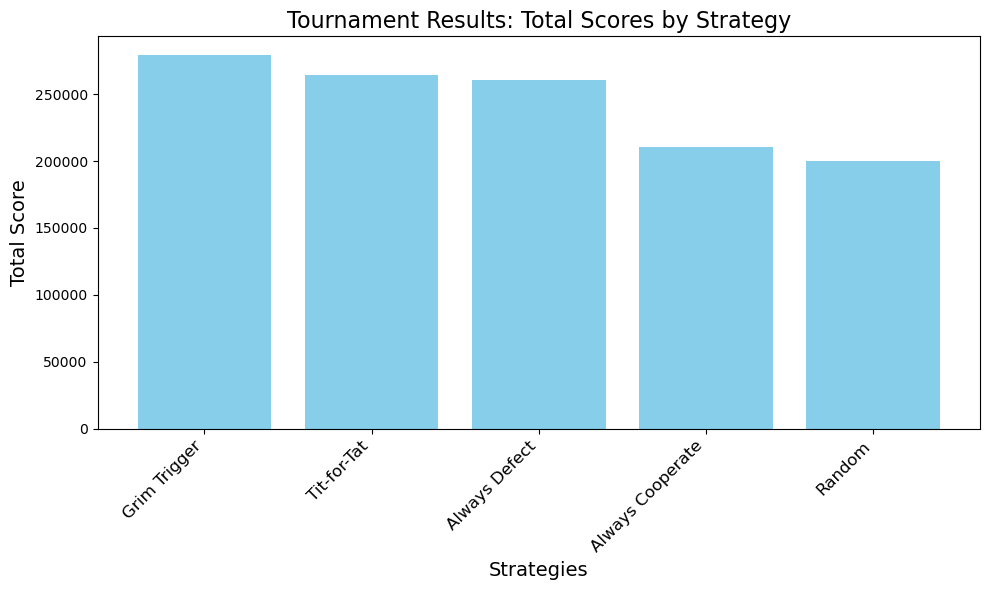

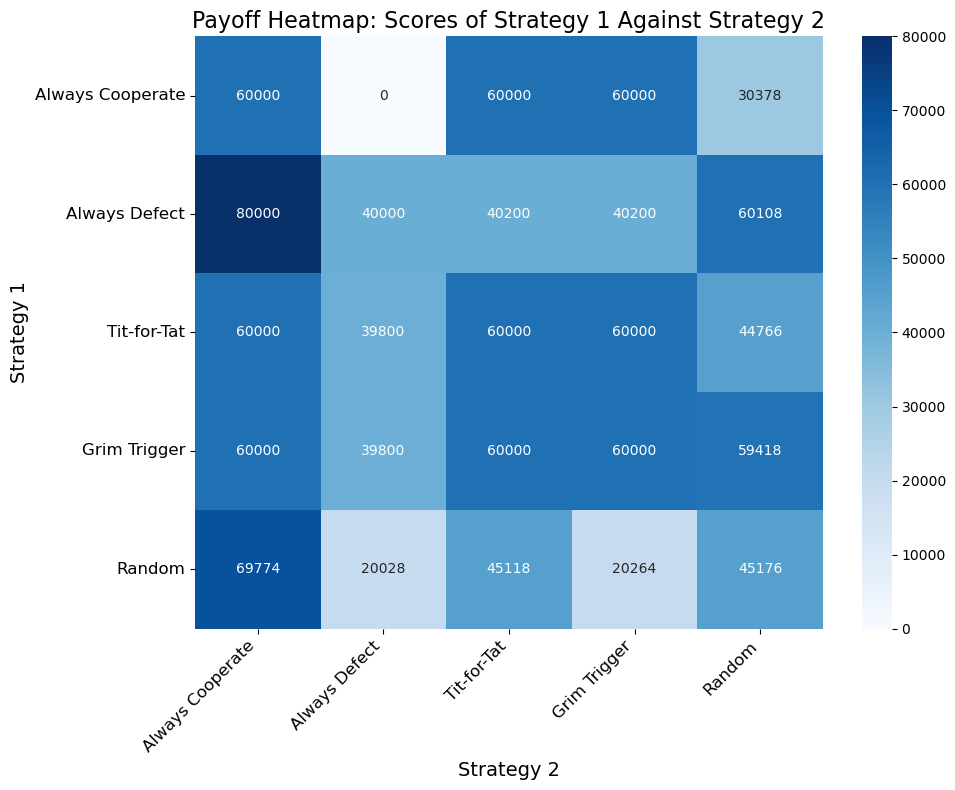

In [67]:
if __name__ == "__main__":
    run_simulation()